## Setup

In [1]:
%autosave 30
%load_ext autoreload
%autoreload 2

Autosaving every 30 seconds


In [2]:
cd ..

/home/huawei123/kwx1991442/code-classification


In [30]:
import logging
from src.main import parse_args

logging.basicConfig(
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',
    level=logging.INFO
)
logger = logging.getLogger(__name__)


args = parse_args(True, 
    ["--method", "baseline", 
    "--exp-name", "EXPLORE-FILES-AND-FOLDER"]
)

## Imports

In [4]:
import os
from statistics import mean

from src.baseline.dataloader import UITestsDataset
from src.params import PATH_TEST_UI

In [5]:
dataset = UITestsDataset(PATH_TEST_UI, 'train')
items = dataset.items 

In [6]:
sizes_of_files = {folder : [] for folder in dataset.classes}
for item in dataset.items:
    folder = item.relpath.split(os.sep)[0]
    text = dataset.item2text(item)
    sizes_of_files[folder].append(len(text))

In [7]:
number_of_files = [len(value) for value in sizes_of_files.values()]
mean_length_of_text = [mean(value) for value in sizes_of_files.values()]

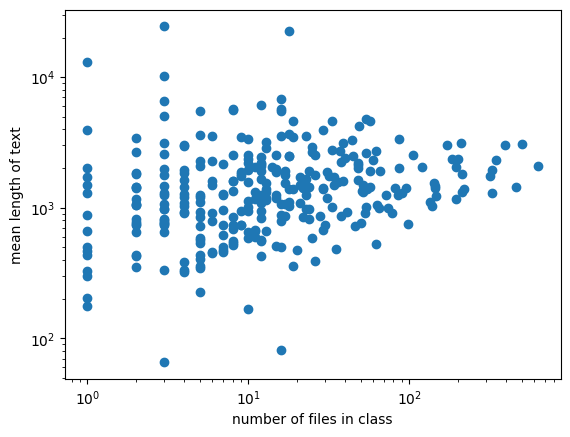

In [8]:
import matplotlib.pyplot as plt
import numpy as np

plt.scatter(number_of_files, mean_length_of_text)
plt.yscale('log'); plt.xscale('log')
plt.xlabel('number of files in class')
plt.ylabel('mean length of text')
plt.show()

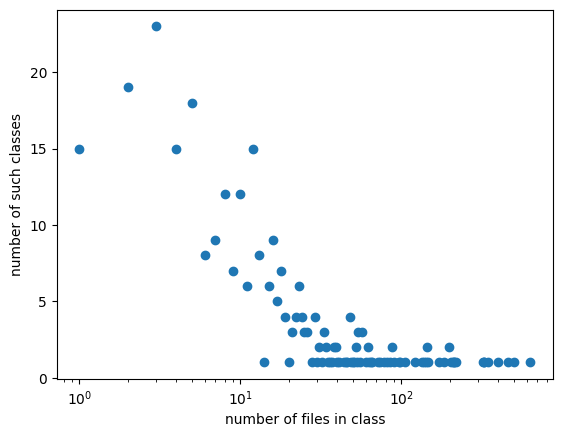

In [9]:
number_of_files = np.array(number_of_files)
u, c, = np.unique(number_of_files, return_counts=True)
plt.scatter(u, c)
plt.xscale('log')
plt.xlabel('number of files in class'); plt.ylabel('number of such classes')
plt.show()

In [10]:
print(f"outline:")
for _u, _c in zip(u, c):
    print(f'{_c} classes with {_u} files')

outline:
15 classes with 1 files
19 classes with 2 files
23 classes with 3 files
15 classes with 4 files
18 classes with 5 files
8 classes with 6 files
9 classes with 7 files
12 classes with 8 files
7 classes with 9 files
12 classes with 10 files
6 classes with 11 files
15 classes with 12 files
8 classes with 13 files
1 classes with 14 files
6 classes with 15 files
9 classes with 16 files
5 classes with 17 files
7 classes with 18 files
4 classes with 19 files
1 classes with 20 files
3 classes with 21 files
4 classes with 22 files
6 classes with 23 files
4 classes with 24 files
3 classes with 25 files
3 classes with 26 files
1 classes with 28 files
4 classes with 29 files
1 classes with 30 files
2 classes with 31 files
1 classes with 32 files
3 classes with 33 files
2 classes with 34 files
1 classes with 35 files
1 classes with 36 files
1 classes with 37 files
2 classes with 38 files
2 classes with 39 files
1 classes with 40 files
1 classes with 41 files
1 classes with 44 files
1 classe

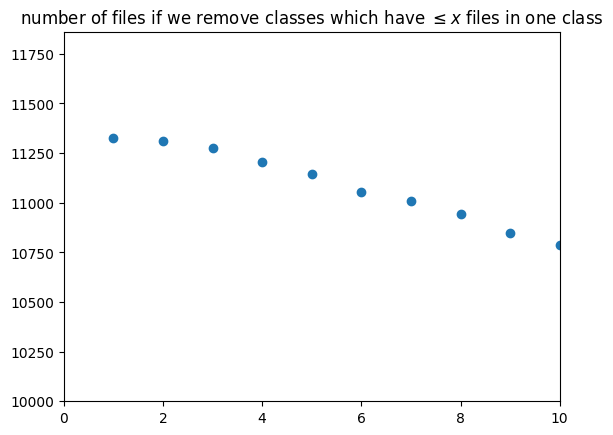

In [17]:
plt.scatter(u, np.cumsum((c*u)[::-1])[::-1])
plt.xlim((0, 10)); plt.ylim((10000))
plt.title(r'number of files if we remove classes which have $\leq x$ files in one class')
plt.show()

Text(0.5, 1.0, 'number of classes if we remove classes which have $\\leq x$ files in one class')

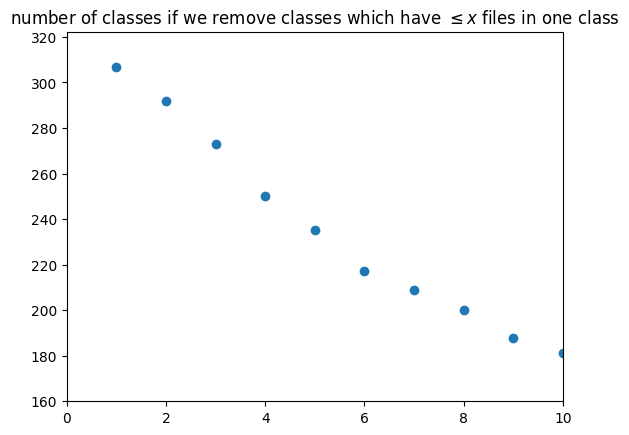

In [16]:
plt.scatter(u, np.cumsum((c)[::-1])[::-1])
plt.xlim((0, 10)); plt.ylim((160))
plt.title(r'number of classes if we remove classes which have $\leq x$ files in one class')

**Idea**: let's remove classes with $\leq$ 8 files!

In [37]:
from src.baseline.dataloader import UITestsDataset, Item
from typing import *

MIN_NUMBER_OF_FILES_IN_CLASS = 8

class RemovedBadClasses(UITestsDataset):
    def __init__(self, tests_ui_folder: str = PATH_TEST_UI, mode: str = 'train', debug: bool = False,
        min_number_of_files_in_class: int = MIN_NUMBER_OF_FILES_IN_CLASS
        ) -> None:
        self.min_number_of_files_in_class = min_number_of_files_in_class
        super().__init__(tests_ui_folder, mode, debug)

    def get_items(self, test_ui_folder: str, mode: str, debug: bool = False) -> List[Item]:
        items = super().get_items(test_ui_folder, mode, debug)

        if mode == 'train' and self.min_number_of_files_in_class > 0:
            # Estimate number of files in each class        
            sizes = {}
            for item in items:
                folder = item.relpath.split(os.sep)[0]
                if folder in sizes:
                    sizes[folder] += 1
                else:
                    sizes[folder] = 1

            # Remove items with small number of files in thier class
            items_with_small_classes, items_with_fine_classes = [], []
            for item in items:
                folder = item.relpath.split(os.sep)[0]
                if sizes[folder] > self.min_number_of_files_in_class:
                    items_with_fine_classes.append(item)
                else:
                    items_with_small_classes.append(item)
            
            logger.info(f"Removing data with low population classes. "
                        f"{len(items_with_small_classes)} are removed. "
                        f"{len(items_with_fine_classes)} are left. ")
        return items_with_fine_classes

In [43]:
dataset = RemovedBadClasses(PATH_TEST_UI, 'train', min_number_of_files_in_class=10)

2023-08-25 20:16:29,490 - __main__ - INFO - Removing data with low population classes. 662 are removed. 10665 are left. 
